### Overview
This notebook attempts to address the discrepancy in locking between observed data and the circulating supply model.  Likely, this is due to the unknown unlocking distribution of known sectors.

### Approach
In this notebook, our approach is to train a MLP that will learn the error in the forecasting model and the actual data from starboard.

We use the following features for training (this can be added to/subtracted from easily):
 - Network RBP
 - Network QAP
 - Network Locked
    
Before we explain how we generate training data, we must explain how the circulating supply model works. In mechaFIL and mechaFIL-JAX, there is a configuration for `start_date` and `current_date`.  
 - `start_date` - the date from which historical data is used to seed the simulation.
 - `current_date` - the date from which forecasting happens
    
Now, we have historical data from starboard until approximately `today`.  We also know that the locking modeling error accumulates over time. With this in mind, we generate data as follows:
 1. We pick a random `start_date`
 2. We set `current_date` to `today`
 3. We forecast for 1 day.
 4. We drop all forecasting data and only keep the historical data.
     a. Note: the way the supply code works is that it computes supply statistics from `start_date` to `end_date`. We only keep the data from `start_date` to `current_date`.
 5. X = We extract other data that we want to use for prediction.  In this case, this is the features above.
 6. y = We extract the ground truth locking data from starboard.
 7. Use X & y to train the NN.
 
* Note: in reality, `today` is actually `today-timedelta(days=3)` due to data aggregation delays in Starboard.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from typing import Sequence
import os

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import random

import optax
from jaxopt import OptaxSolver
from jaxopt import objective

import flax.linen as nn

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

import cel_utils.disk_utils as du

from tqdm.auto import tqdm

In [3]:
import mechafil.data as mecha_data
from datetime import date, timedelta

start_date = date(2021, 3, 15)
current_date = date.today() - timedelta(days=3)

In [4]:
auth_token_fp = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
offline_data = 'offline'
os.makedirs(offline_data, exist_ok=True)

In [6]:
# setup data from starboard
mecha_data.setup_spacescope(auth_token_fp)

@du.cache_data(directory=offline_data)
def get_groundtruth():
    stats_df = mecha_data.spacescope_obj.query_spacescope_supply_stats(start_date, current_date)
    return {
        'stats_df': stats_df
    }

ground_truth_data = get_groundtruth()
locals().update(ground_truth_data)

In [23]:
# generate all data needed to run model
# This generates the historical data w/ the correct offsets to run the model
current_date = date.today() - timedelta(days=3)
forecast_length = 1
end_date = current_date + timedelta(days=forecast_length)
    
@du.cache_data(directory=offline_data)
def get_all_jax_data():
    days_delta = 30
    hash_index = 0
    model_data = {}

    loop_start_date = date(2021, 3, 15)
    num_iter = (current_date - loop_start_date).days // days_delta
    pbar = tqdm(total=num_iter)
    while loop_start_date + timedelta(days=days_delta) < current_date:
        x = data.get_simulation_data(auth_token_fp, loop_start_date, current_date, end_date)
        model_data[hash_index] = x

        loop_start_date += timedelta(days=days_delta)
        hash_index += 1
        pbar.update(1)
        
    return model_data

jax_offline_data = get_all_jax_data()
sim_start_hashes = jnp.array(list(jax_offline_data.keys()))

In [8]:
class RegressionModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [9]:
# TODO: revisit
num_features = 4

model = RegressionModel()
batch = jnp.ones((1, num_features))
init_params = model.init(jax.random.PRNGKey(0), batch)

In [56]:
def ridge_reg_objective(params, l2reg, data):
    X, y = data
    preds = model.apply(params, X)
    residuals = preds - y
    w = jnp.concatenate((params['params']['Dense_0']['kernel'].flatten(), params['params']['Dense_1']['kernel'].flatten()))
    return jnp.mean(residuals ** 2) + 0.5 * l2reg * jnp.sum(w ** 2)

In [57]:
# Define a function to generate data on the fly
def data_iterator():
    key = random.PRNGKey(1)
    while True:
        key, subkey = random.split(key)
        
        simulation_start_hash = int(random.choice(subkey, sim_start_hashes))
        simulation_offline_data = jax_offline_data[simulation_start_hash]
        
        start_date = date(2021, 3, 15) + timedelta(days=30)*simulation_start_hash
        
        # static inputs
        current_date = date.today() - timedelta(days=3)
        forecast_length = 1
        sector_duration = 360

        # these are noops
        rbp_val = 6
        rr_val = 0.6
        fpr_val = 0.6
        rbp = jnp.ones(forecast_length) * rbp_val
        rr = jnp.ones(forecast_length) * rr_val
        fpr = jnp.ones(forecast_length) * fpr_val
        lock_target=0.3

        simulation_results = sim.run_sim(
            rbp,
            rr,
            fpr,
            lock_target,

            start_date,
            current_date,
            forecast_length,
            sector_duration,
            simulation_offline_data
        )
        rbp = simulation_results['network_RBP_EIB'][:-1]
        qap = simulation_results['network_QAP_EIB'][:-1]
        baseline = simulation_results['network_baseline_EIB'][:-1]
        locked_M = simulation_results['network_locked'][:-1] / 1e6
        X = jnp.vstack((rbp, qap, baseline, locked_M)).T
        
        l = len(rbp)
        y = jnp.array(stats_df['locked_fil'].iloc[-l:].values / 1e6)
        
        yield X, y
        
def loss_fn(params):
    X_batch, y_batch = next(data_generator())
    return mse_loss(params, X_batch, y_batch)

In [58]:
lr = 1e-3
l2reg=0.1
maxiter=1000
opt = optax.adam(lr)
solver = OptaxSolver(opt=opt, fun=ridge_reg_objective, maxiter=maxiter)

In [59]:
iterator = data_iterator()
state = solver.init_state(init_params, l2reg=l2reg)
params = init_params
error_tracking = np.zeros(maxiter)
for ii in tqdm(range(maxiter)):
    data = next(iterator)
    params, state = solver.update(params, state, l2reg=l2reg, data=data)
    error_tracking[ii] = state.error

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


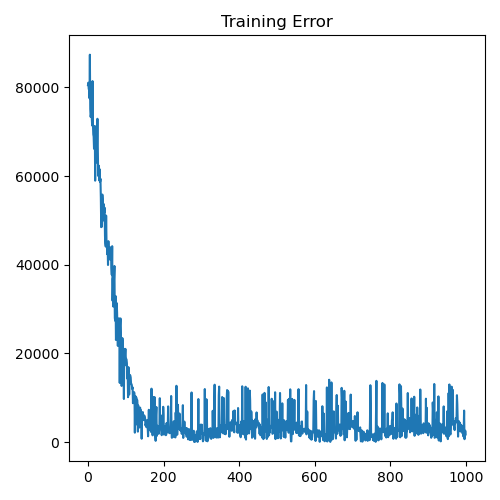

In [60]:
plt.figure(figsize=(5,5))
plt.plot(error_tracking)
plt.title('Training Error')

plt.tight_layout()

In [61]:
# lets apply the model to start forecasting from the start_date and compare the locking errors with and without the NN

# run the model as is
simulation_start_hash = 0  # this means start from the earliest possible date.
                           # this is the case where errors can accumulate the most
simulation_offline_data = jax_offline_data[simulation_start_hash]

start_date = date(2021, 3, 15) + timedelta(days=30)*simulation_start_hash

# static inputs
current_date = date.today() - timedelta(days=3)
forecast_length = 1
sector_duration = 360

# these are noops
rbp_val = 6
rr_val = 0.6
fpr_val = 0.6
rbp = jnp.ones(forecast_length) * rbp_val
rr = jnp.ones(forecast_length) * rr_val
fpr = jnp.ones(forecast_length) * fpr_val
lock_target=0.3

simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    simulation_offline_data
)

In [62]:
rbp = simulation_results['network_RBP_EIB'][:-1]
qap = simulation_results['network_QAP_EIB'][:-1]
baseline = simulation_results['network_baseline_EIB'][:-1]
locked_M = simulation_results['network_locked'][:-1] / 1e6
X_pred = jnp.vstack((rbp, qap, baseline, locked_M)).T
l = len(locked_M)
locked_true = jnp.array(stats_df['locked_fil'].iloc[-l:].values / 1e6)
y_pred = model.apply(params, X_pred)

<IPython.core.display.Javascript object>


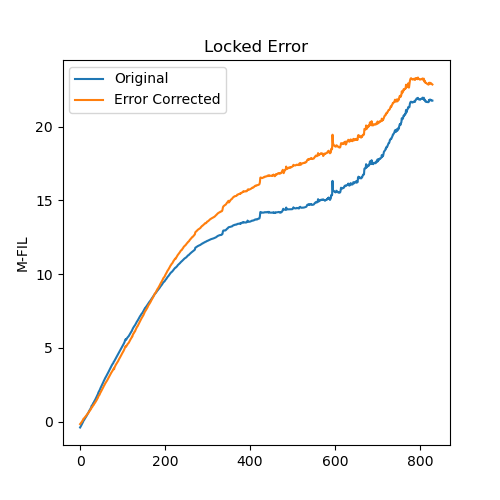

In [63]:
plt.figure(figsize=(5,5))
plt.plot(locked_M-locked_true, label='Original')
plt.plot(y_pred.squeeze()-locked_true, label='Error Corrected')
plt.ylabel('M-FIL')
plt.title('Locked Error')
plt.legend()